In [1]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import integrate
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve


conn = create_engine('postgresql://ubuntu@52.53.236.232:5432/collegesc')

%matplotlib inline

## Helper functions and other definitions

In [2]:
def query_data_def(conn, var_name):
    """
    var_name: name of column to query
    returns query from datadefinitions table showing definition of data
    """
    query = "SELECT * FROM datadefinitions WHERE developername='"+var_name+"';"
    return conn.execute(query).fetchall()

def check_highnull_columns(df, threshold=1000):
    """
    takes a dataframe and checks which columns
    have lower than threshold nulls
    returns partial dataframe with columns with low nulls
    """
    return df.loc[:, df.isnull().sum() < threshold]

def fit_and_show_metrics(model_dict, X_train, X_test, y_train, y_test):
    """
    Takes a dictionary of models, the training and test sets,
    and plots their ROC and Precision-Recall curves
    Then, returns the fitted models
    """
    for key in model_dict.keys():
        model_dict[key].fit(X_train, y_train)
        model_prob = model_dict[key].predict_proba(X_test)[:, 1]
    

        fpr, tpr, thresholds = roc_curve(y_test, model_prob)
        auc_score = integrate.trapz(tpr, x=fpr)
        
        prec, recall, thresholds = precision_recall_curve(y_test, model_prob)
        
        model_ll = log_loss(y_test, model_prob)
        
        print(key)
        print("AUC score: {}".format(auc_score))
        print("Log loss: {}".format(model_ll))
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        fig.suptitle(key)
        axes[0].plot(fpr, tpr)
        axes[0].plot(np.linspace(0,1,3),np.linspace(0,1,3))
        axes[0].set_xlabel("False Positive Rate")
        axes[0].set_ylabel("True Positive Rate")
        
        axes[1].plot(prec, recall)
        axes[1].set_xlabel("Precision")
        axes[1].set_ylabel("Recall")
        
        plt.show()
        

    return model_dict

## Start with school table

In [3]:
school_all = """SELECT * FROM school;"""

In [4]:
school_df = pd.read_sql_query(school_all, conn)

In [5]:
school_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 43 columns):
index                                   7703 non-null int64
id                                      7703 non-null int64
location.lat                            7703 non-null float64
location.lon                            7703 non-null float64
accreditor                              6805 non-null object
alias                                   2178 non-null object
branches                                7703 non-null int64
carnegie_basic                          7282 non-null float64
carnegie_size_setting                   7282 non-null float64
carnegie_undergrad                      7282 non-null float64
city                                    7703 non-null object
degree_urbanization                     0 non-null object
degrees_awarded.highest                 7703 non-null int64
degrees_awarded.predominant             7703 non-null int64
degrees_awarded.predominant_recoded     0 

In [6]:
school_df.operating.value_counts()

1    6893
0     810
Name: operating, dtype: int64

### Remove uninteresting columns or columns with explicit or encoded nulls

In [7]:
school_columns = list(school_df.columns.values)

In [8]:
school_columns.remove('index')
school_columns.remove('alias')
school_columns.remove('degree_urbanization')
school_columns.remove('degrees_awarded.predominant_recoded')
school_columns.remove('faculty_salary')
school_columns.remove('ft_faculty_rate')
school_columns.remove('price_calculator_url')
school_columns.remove('url')
school_columns.remove('zip')
school_columns.remove('carnegie_basic')
school_columns.remove('carnegie_size_setting')
school_columns.remove('carnegie_undergrad')
school_columns.remove('online_only')
school_columns.remove('accreditor')
school_columns.remove('under_investigation')

## Get columns from student table next

In [9]:
student_all = "SELECT * FROM student;"

In [10]:
student_df = pd.read_sql_query(student_all, conn)

In [11]:
student_lownull_df = check_highnull_columns(student_df, threshold=2000)

In [12]:
student_lownull_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 39 columns):
index                                             7703 non-null int64
FAFSA_applications                                7204 non-null float64
avg_dependent_income.2014dollars                  6835 non-null float64
avg_independent_income.2014dollars                6835 non-null float64
demographics.age_entry                            7204 non-null float64
demographics.avg_family_income                    7204 non-null float64
demographics.avg_family_income_independents       6835 non-null float64
demographics.dependent                            6829 non-null float64
demographics.female_share                         6259 non-null float64
demographics.first_generation                     6534 non-null float64
demographics.married                              6495 non-null float64
demographics.median_family_income                 7204 non-null float64
demographics.men               

In [13]:
student_lownull_df['parents_education_level'].describe()

count      6568.000000
mean       4959.635201
std       12477.427315
min          11.000000
25%         320.000000
50%        1074.000000
75%        3380.000000
max      136770.000000
Name: parents_education_level, dtype: float64

In [14]:
student_lownull = list(student_lownull_df.columns.values)

In [15]:
student_lownull.remove('index')
student_lownull.remove('avg_dependent_income.2014dollars')
student_lownull.remove('demographics.avg_family_income')
student_lownull.remove('demographics.avg_family_income_independents')
student_lownull.remove('avg_independent_income.2014dollars')
student_lownull.remove('FAFSA_applications')
student_lownull.remove('family_income.dependent_students')
student_lownull.remove('family_income.independent_students')
student_lownull.remove('family_income.overall')
student_lownull.remove('valid_dependency_status')
student_lownull.remove('parents_education_level')
student_lownull.remove('id')
student_lownull.remove('students_with_pell_grant')
student_lownull

['demographics.age_entry',
 'demographics.dependent',
 'demographics.female_share',
 'demographics.first_generation',
 'demographics.married',
 'demographics.median_family_income',
 'demographics.men',
 'demographics.race_ethnicity.aian',
 'demographics.race_ethnicity.asian',
 'demographics.race_ethnicity.black',
 'demographics.race_ethnicity.hispanic',
 'demographics.race_ethnicity.nhpi',
 'demographics.race_ethnicity.non_resident_alien',
 'demographics.race_ethnicity.two_or_more',
 'demographics.race_ethnicity.unknown',
 'demographics.race_ethnicity.white',
 'demographics.women',
 'fafsa_sent.2_college_allyrs',
 'part_time_share',
 'share_25_older',
 'share_firstgeneration',
 'share_firstgeneration_parents.somecollege',
 'share_independent_students',
 'share_lowincome.0_30000',
 'share_middleincome.30001_48000',
 'size']

## Select only interesting features and add/recode features

In [16]:
operating_query = 'SELECT \n school."' + '",school."'.join(school_columns) + '",repayment."3_yr_default_rate"'
operating_query += ', aid."federal_loan_rate", aid."pell_grant_rate",student."'
operating_query += '",student."'.join(student_lownull)+'"'
operating_query += """                       
                    FROM 
                        school
                    JOIN repayment ON school.id=repayment.id
                    JOIN aid ON school.id=aid.id
                    JOIN student ON school.id=student.id;"""
operating_query

'SELECT \n school."id",school."location.lat",school."location.lon",school."branches",school."city",school."degrees_awarded.highest",school."degrees_awarded.predominant",school."institutional_characteristics.level",school."instructional_expenditure_per_fte",school."locale",school."main_campus",school."men_only",school."minority_serving.aanipi",school."minority_serving.annh",school."minority_serving.hispanic",school."minority_serving.historically_black",school."minority_serving.nant",school."minority_serving.predominantly_black",school."minority_serving.tribal",school."name",school."operating",school."ownership",school."region_id",school."religious_affiliation",school."state",school."state_fips",school."tuition_revenue_per_fte",school."women_only",repayment."3_yr_default_rate", aid."federal_loan_rate", aid."pell_grant_rate",student."demographics.age_entry",student."demographics.dependent",student."demographics.female_share",student."demographics.first_generation",student."demographics.ma

In [17]:
school_df = pd.read_sql_query(operating_query, conn)

In [18]:
school_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 57 columns):
id                                                7703 non-null int64
location.lat                                      7703 non-null float64
location.lon                                      7703 non-null float64
branches                                          7703 non-null int64
city                                              7703 non-null object
degrees_awarded.highest                           7703 non-null int64
degrees_awarded.predominant                       7703 non-null int64
institutional_characteristics.level               7703 non-null int64
instructional_expenditure_per_fte                 7270 non-null float64
locale                                            7282 non-null float64
main_campus                                       7703 non-null int64
men_only                                          7282 non-null float64
minority_serving.aanipi                   

### Recode locale to 4 values instead of 12

In [19]:
locale_recode = school_df.locale.astype(str).values

In [20]:
locale_recode = [int(x[0]) if x[0] in ['1','2','3'] else 0 for x in locale_recode]

In [21]:
school_df['locale_recode'] = locale_recode

In [22]:
school_df['locale_recode'].value_counts()

1    3509
2    2291
0     986
3     917
Name: locale_recode, dtype: int64

### Recode religion to religious and non-religious

In [23]:
religion_recode = (np.nan_to_num(school_df.religious_affiliation.values) > 0).astype(int)

In [24]:
np.unique(religion_recode)

array([0, 1])

In [25]:
school_df['religion_recode'] = religion_recode

In [26]:
school_df.religion_recode.value_counts()

0    6793
1     910
Name: religion_recode, dtype: int64

### Recode gender-specific schools

In [27]:
school_df['gender_specific'] = np.nan_to_num((school_df.men_only + school_df.women_only).values)

In [28]:
school_df.gender_specific.value_counts()

0.0    7598
1.0     105
Name: gender_specific, dtype: int64

### Recode minority-serving schools

In [29]:
minority_specific = np.nan_to_num((school_df['minority_serving.aanipi'] +\
                        school_df['minority_serving.annh'] +\
                        school_df['minority_serving.hispanic'] +\
                        school_df['minority_serving.historically_black'] +\
                        school_df['minority_serving.nant'] +\
                        school_df['minority_serving.predominantly_black'] +\
                        school_df['minority_serving.tribal']).values)

In [30]:
minority_specific = (minority_specific > 0).astype(int)

In [31]:
school_df['minority_specific'] = minority_specific

### Recode for-profit vs. non-profit (private or public)

In [32]:
school_df['for_profit'] = (school_df.ownership == 3).astype(int)

In [33]:
school_df.for_profit.value_counts()

0    4000
1    3703
Name: for_profit, dtype: int64

### Impute continuous variables with mean

In [34]:
continuous_vars = ['instructional_expenditure_per_fte', 'tuition_revenue_per_fte', '3_yr_default_rate',
                  'federal_loan_rate', 'pell_grant_rate', 'demographics.age_entry', 
                  'demographics.dependent', 'demographics.female_share', 'demographics.married',
                  'demographics.median_family_income', 'demographics.race_ethnicity.aian',
                   'demographics.race_ethnicity.asian','demographics.race_ethnicity.black',
                   'demographics.race_ethnicity.hispanic','demographics.race_ethnicity.nhpi',
                   'demographics.race_ethnicity.non_resident_alien',
                   'demographics.race_ethnicity.two_or_more',
                   'demographics.race_ethnicity.unknown','demographics.race_ethnicity.white',
                   'fafsa_sent.2_college_allyrs', 'part_time_share','share_25_older',
                   'share_firstgeneration','share_firstgeneration_parents.somecollege',
                   'share_independent_students','share_lowincome.0_30000',
                   'share_middleincome.30001_48000','size']


In [35]:
for var in continuous_vars:
    school_df[var].fillna(school_df[var].mean(), inplace=True)
    

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


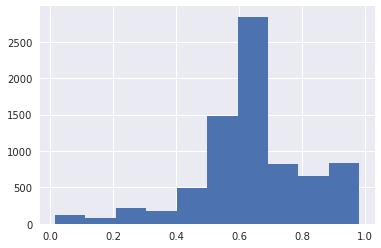

In [36]:
school_df['demographics.female_share'].hist()

In [37]:
school_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 62 columns):
id                                                7703 non-null int64
location.lat                                      7703 non-null float64
location.lon                                      7703 non-null float64
branches                                          7703 non-null int64
city                                              7703 non-null object
degrees_awarded.highest                           7703 non-null int64
degrees_awarded.predominant                       7703 non-null int64
institutional_characteristics.level               7703 non-null int64
instructional_expenditure_per_fte                 7703 non-null float64
locale                                            7282 non-null float64
main_campus                                       7703 non-null int64
men_only                                          7282 non-null float64
minority_serving.aanipi                   

### Pare down to relevant columns

In [40]:
cleaned_school_df = school_df.drop(['locale', 'men_only',
                                    'minority_serving.aanipi', 'minority_serving.annh',
                                    'minority_serving.hispanic', 'minority_serving.historically_black',
                                    'minority_serving.nant', 'minority_serving.predominantly_black',
                                    'minority_serving.tribal', 'religious_affiliation', 'state', 
                                    'state_fips','women_only', 'demographics.men',
                                    'demographics.women', 'demographics.first_generation'], axis = 1)

In [41]:
cleaned_school_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 46 columns):
id                                                7703 non-null int64
location.lat                                      7703 non-null float64
location.lon                                      7703 non-null float64
branches                                          7703 non-null int64
city                                              7703 non-null object
degrees_awarded.highest                           7703 non-null int64
degrees_awarded.predominant                       7703 non-null int64
institutional_characteristics.level               7703 non-null int64
instructional_expenditure_per_fte                 7703 non-null float64
main_campus                                       7703 non-null int64
name                                              7703 non-null object
operating                                         7703 non-null int64
ownership                                    

In [42]:
cleaned_school_df['not_operating'] =  1 - cleaned_school_df.operating

In [43]:
cleaned_school_df.not_operating.value_counts()

0    6893
1     810
Name: not_operating, dtype: int64

## Select columns for classification


In [61]:
X = cleaned_school_df.drop(['id', 'city', 'name', 'ownership', 'region_id', 'operating', 'not_operating'], axis = 1)
y = cleaned_school_df.not_operating

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


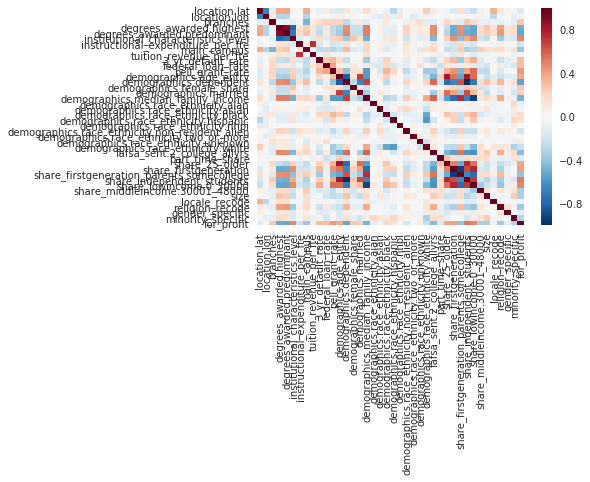

In [45]:
sns.heatmap(X.corr())

### Split data, run several models

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [63]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression



In [80]:
models = dict()
models['Logistic L1'] = LogisticRegression(penalty='l1', C=0.5)
models['Logistic L2'] = LogisticRegression(C=0.5)
models['KNN'] = KNeighborsClassifier(n_neighbors=6)
models['Tree'] = DecisionTreeClassifier()
models['RandomForest'] = RandomForestClassifier(n_estimators=1000)
models['GradBoostTrees'] = GradientBoostingClassifier()

Logistic L1
AUC score: 0.8286009703332538
Log loss: 0.2172170388230416


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


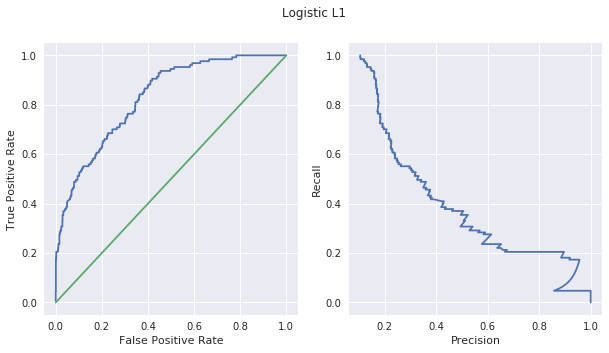

Logistic L2
AUC score: 0.7960794673393099
Log loss: 0.23179213412019778


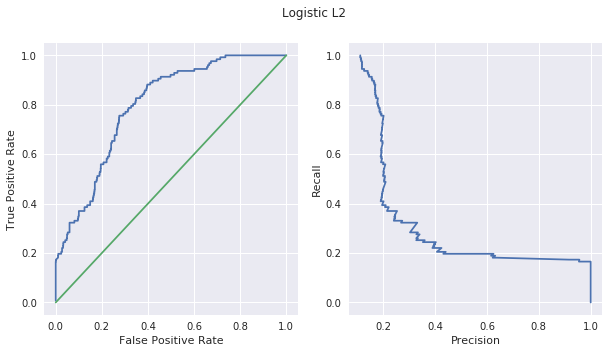

KNN
AUC score: 0.7361835452386634
Log loss: 1.0496367830982156


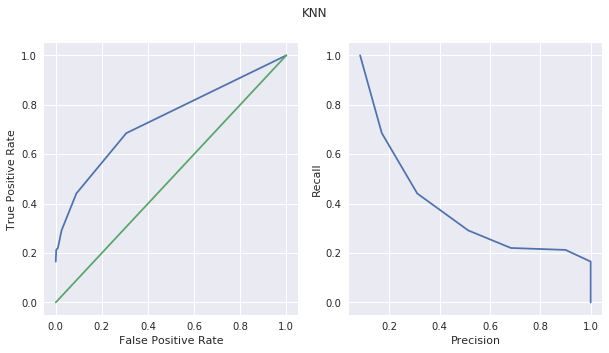

Tree
AUC score: 0.6834429787185694
Log loss: 3.659192080961264


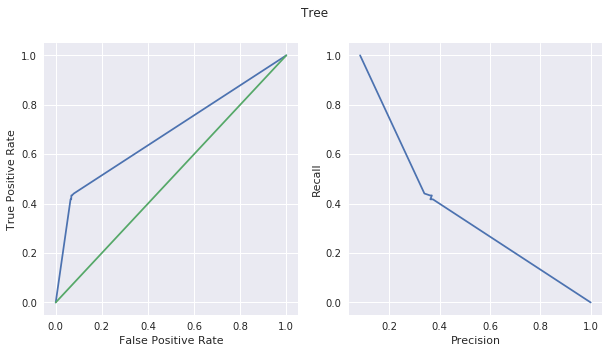

RandomForest
AUC score: 0.8904966424651464
Log loss: 0.17642920857983074


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


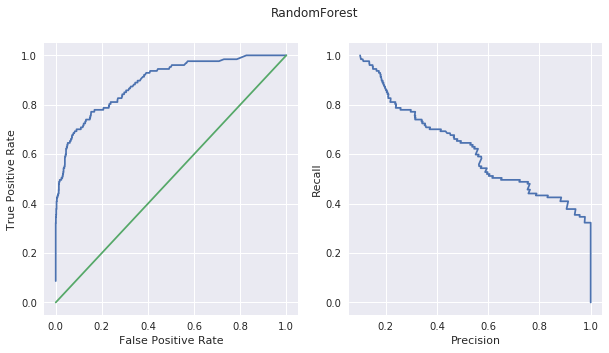

GradBoostTrees
AUC score: 0.8756973560123166
Log loss: 0.18646739617755115


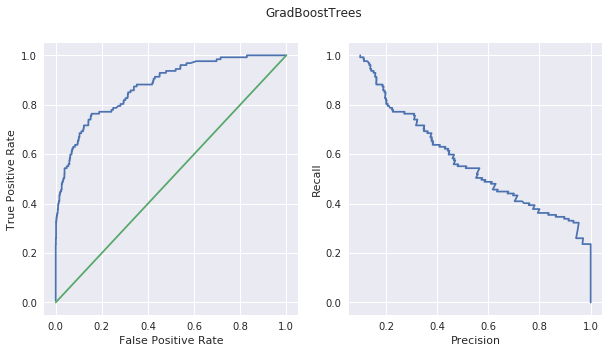

In [81]:
fit_models = fit_and_show_metrics(models, X_train, X_test, y_train, y_test)

### Check features in best models

In [82]:
sorted(list(zip(X.columns, models['Logistic L1'].coef_[0])), key = lambda x: x[1], reverse=True)

[('demographics.race_ethnicity.unknown', 3.7432242334336698),
 ('demographics.race_ethnicity.two_or_more', 2.4185045771324556),
 ('fafsa_sent.2_college_allyrs', 1.0667903059621411),
 ('3_yr_default_rate', 0.89761747401779568),
 ('pell_grant_rate', 0.75001507118171329),
 ('demographics.female_share', 0.55195047579631062),
 ('share_25_older', 0.48207110600837944),
 ('for_profit', 0.45433317381984994),
 ('religion_recode', 0.042265112108793405),
 ('location.lat', 0.0067806779296753954),
 ('location.lon', 0.0041715966222697614),
 ('branches', 0.0034113492422677459),
 ('tuition_revenue_per_fte', 1.8862869222783919e-05),
 ('instructional_expenditure_per_fte', 8.315199754568771e-06),
 ('institutional_characteristics.level', 0.0),
 ('federal_loan_rate', 0.0),
 ('demographics.dependent', 0.0),
 ('demographics.married', 0.0),
 ('demographics.race_ethnicity.aian', 0.0),
 ('demographics.race_ethnicity.asian', 0.0),
 ('demographics.race_ethnicity.black', 0.0),
 ('demographics.race_ethnicity.nhpi', 

In [83]:
sorted(list(zip(X.columns, models['RandomForest'].feature_importances_)), key = lambda x: x[1], reverse=True)

[('branches', 0.059785899321479673),
 ('demographics.median_family_income', 0.047431354566929193),
 ('demographics.female_share', 0.045918445684938983),
 ('demographics.race_ethnicity.unknown', 0.041819196979547064),
 ('instructional_expenditure_per_fte', 0.039424450771355493),
 ('size', 0.039355420895430059),
 ('3_yr_default_rate', 0.038462152651110117),
 ('tuition_revenue_per_fte', 0.037335955145035654),
 ('location.lat', 0.037189995297499549),
 ('location.lon', 0.034449527836983129),
 ('pell_grant_rate', 0.032696068878602803),
 ('share_middleincome.30001_48000', 0.032249132323830747),
 ('demographics.dependent', 0.031736034393273931),
 ('share_lowincome.0_30000', 0.031386033488008475),
 ('share_independent_students', 0.030853444263806287),
 ('demographics.married', 0.02899049027084618),
 ('fafsa_sent.2_college_allyrs', 0.028377626736448398),
 ('share_firstgeneration', 0.02611104482417061),
 ('demographics.race_ethnicity.two_or_more', 0.02540165571989085),
 ('demographics.race_ethnic

In [84]:
sorted(list(zip(X.columns, models['GradBoostTrees'].feature_importances_)), key = lambda x: x[1], reverse=True)

[('branches', 0.087125539902563456),
 ('demographics.female_share', 0.068752946983962213),
 ('size', 0.061071697907914203),
 ('share_middleincome.30001_48000', 0.059485605870443478),
 ('instructional_expenditure_per_fte', 0.053289923241396246),
 ('demographics.race_ethnicity.unknown', 0.049607253061532089),
 ('fafsa_sent.2_college_allyrs', 0.048000298553116716),
 ('share_firstgeneration_parents.somecollege', 0.04369995245964934),
 ('share_lowincome.0_30000', 0.039803493408457589),
 ('tuition_revenue_per_fte', 0.037960737277794608),
 ('demographics.median_family_income', 0.037409125171591673),
 ('demographics.race_ethnicity.hispanic', 0.032076900524759928),
 ('location.lat', 0.030849600542308502),
 ('share_25_older', 0.03006289637507115),
 ('3_yr_default_rate', 0.029417907486623655),
 ('for_profit', 0.029078494360426997),
 ('pell_grant_rate', 0.027026734708915381),
 ('demographics.race_ethnicity.two_or_more', 0.026374057169542161),
 ('demographics.married', 0.024634665109838919),
 ('dem

Both random forest and gradient boosted trees latched onto "branches" since 144 of the schools that closed were the branches of ITT Tech. Try running again without ITT Tech.

In [85]:
cleaned_school_df.loc[cleaned_school_df.branches > 60, ['name', 'not_operating', 'branches']].head(10)

,name,not_operating,branches
31,ITT Technical Institute-Albany,1,142
32,ITT Technical Institute-Liverpool,1,142
45,ITT Technical Institute-Saint Rose,1,142
138,Strayer University-Cedar Hill,0,80
139,Strayer University-North Dallas,0,80
140,Strayer University-San Antonio,0,80
141,Strayer University-Stafford,0,80
348,ITT Technical Institute-Pensacola,1,142
349,ITT Technical Institute-San Antonio East,1,142
556,ITT Technical Institute-Marlton,1,142


In [86]:
X, y = X.loc[X.branches != 142], y.loc[X.branches != 142]

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [88]:
models_noITT = dict()
models_noITT['Logistic L1'] = LogisticRegression(penalty='l1', C = 0.5)
models_noITT['Logistic L2'] = LogisticRegression(C=0.5)
models_noITT['KNN'] = KNeighborsClassifier(n_neighbors=6)
models_noITT['Tree'] = DecisionTreeClassifier()
models_noITT['RandomForest'] = RandomForestClassifier(n_estimators=1000)
models_noITT['GradBoostTrees'] = GradientBoostingClassifier()

Logistic L1
AUC score: 0.8287202736021634
Log loss: 0.2171348935623391


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


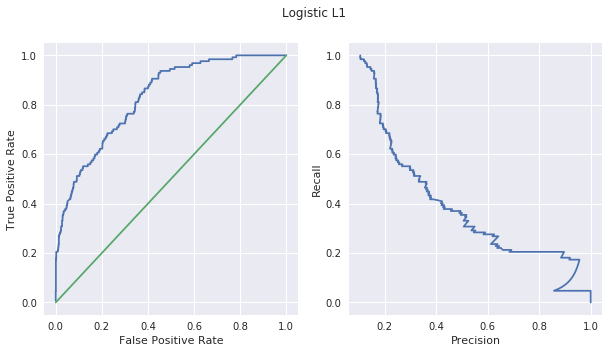

Logistic L2
AUC score: 0.7960794673393099
Log loss: 0.23179213412019778


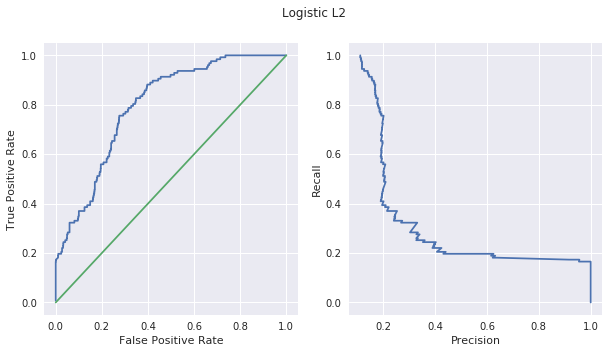

KNN
AUC score: 0.7361835452386634
Log loss: 1.0496367830982156


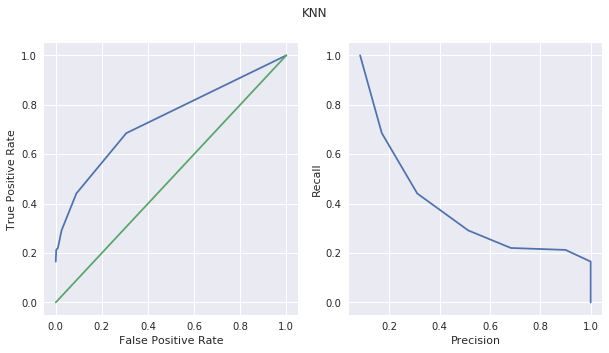

Tree
AUC score: 0.6718904455124928
Log loss: 3.703444319287245


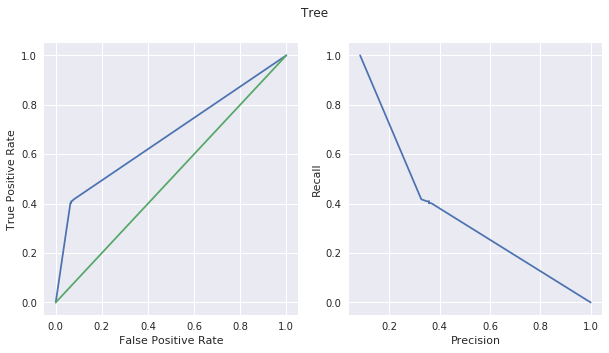

RandomForest
AUC score: 0.8874998579722989
Log loss: 0.21443877450866244


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


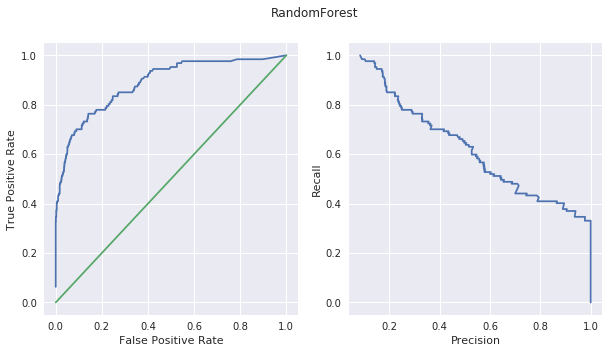

GradBoostTrees
AUC score: 0.8757200804444899
Log loss: 0.18645589290158884


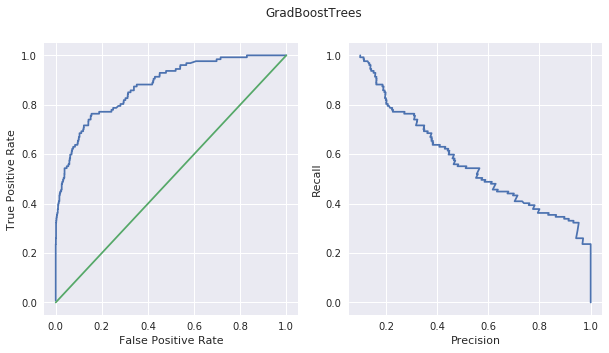

In [89]:
fit_models_noITT = fit_and_show_metrics(models, X_train, X_test, y_train, y_test)

In [95]:
lasso_log_coef = sorted(list(zip(X.columns, fit_models_noITT['Logistic L1'].coef_[0])), key = lambda x: x[1], reverse=True)
lasso_log_coef

[('demographics.race_ethnicity.unknown', 3.7379309167763393),
 ('demographics.race_ethnicity.two_or_more', 2.4191154021736931),
 ('fafsa_sent.2_college_allyrs', 1.0632876749166493),
 ('3_yr_default_rate', 0.8811659605411003),
 ('pell_grant_rate', 0.73278364799972151),
 ('share_25_older', 0.54776460140069316),
 ('demographics.female_share', 0.53782434981023763),
 ('for_profit', 0.45436621518688697),
 ('religion_recode', 0.042674511067523853),
 ('location.lat', 0.0066787698936733074),
 ('location.lon', 0.0042295695718118963),
 ('branches', 0.0035323567053180036),
 ('tuition_revenue_per_fte', 1.8886724052818476e-05),
 ('instructional_expenditure_per_fte', 8.2584687542521022e-06),
 ('institutional_characteristics.level', 0.0),
 ('federal_loan_rate', 0.0),
 ('demographics.dependent', 0.0),
 ('demographics.married', 0.0),
 ('demographics.race_ethnicity.aian', 0.0),
 ('demographics.race_ethnicity.asian', 0.0),
 ('demographics.race_ethnicity.black', 0.0),
 ('demographics.race_ethnicity.nhpi', 

In [96]:
rf_feat_imp = sorted(list(zip(X.columns, fit_models_noITT['RandomForest'].feature_importances_)), key = lambda x: x[1], reverse=True)
rf_feat_imp

[('branches', 0.057488999898235374),
 ('demographics.female_share', 0.046665148348913915),
 ('demographics.median_family_income', 0.046606324639675491),
 ('demographics.race_ethnicity.unknown', 0.043363345496987747),
 ('size', 0.039975178978559268),
 ('instructional_expenditure_per_fte', 0.038444970337986412),
 ('3_yr_default_rate', 0.037680418416075771),
 ('tuition_revenue_per_fte', 0.037594054264942556),
 ('location.lat', 0.037418179777219215),
 ('location.lon', 0.033895655608897061),
 ('share_lowincome.0_30000', 0.032827380559724118),
 ('pell_grant_rate', 0.032804149004213176),
 ('share_middleincome.30001_48000', 0.031899134749282632),
 ('share_independent_students', 0.031236363921015711),
 ('demographics.dependent', 0.031036037107670906),
 ('demographics.married', 0.029639480863050297),
 ('fafsa_sent.2_college_allyrs', 0.02885621746342483),
 ('share_firstgeneration', 0.026044591471637873),
 ('demographics.race_ethnicity.two_or_more', 0.025041216994199887),
 ('demographics.race_ethn

### Plot coefficients for logistic regression and feature importances for RandomForest without ITT Tech

In [99]:
lasso_log_coef_names = [x[0] for x in lasso_log_coef if abs(x[1]) > 0.1]
lasso_log_coefs_imp = [x[1] for x in lasso_log_coef if abs(x[1]) > 0.1]

In [103]:
rf_feat_imp_names = [x[0] for x in rf_feat_imp if x[1] > 0.03]
rf_feat_imp_values = [x[1] for x in rf_feat_imp if x[1] > 0.03]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


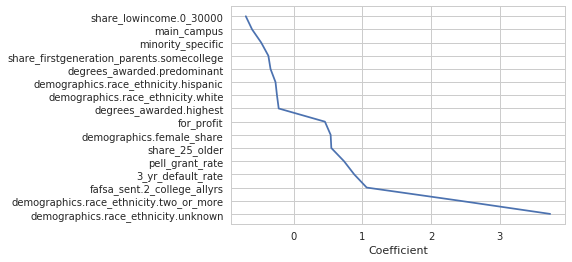

In [107]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1)

ax.plot(lasso_log_coefs_imp, range(len(lasso_log_coef_names)))
plt.yticks(range(len(lasso_log_coef_names)), lasso_log_coef_names)
ax.set_xlabel("Coefficient")

fig.savefig('coefficients_lasso.png', fmt='png', dpi=600, bbox_inches='tight')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


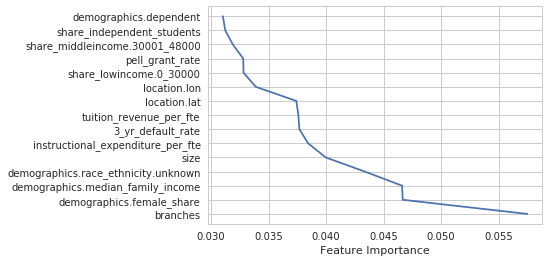

In [108]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1)

ax.plot(rf_feat_imp_values, range(len(rf_feat_imp_names)))
plt.yticks(range(len(rf_feat_imp_names)), rf_feat_imp_names)
ax.set_xlabel("Feature Importance")

fig.savefig('featimp_rf.png', fmt='png', dpi=600, bbox_inches='tight')